In [ ]:
!pip install myplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 23.0 MB/s eta 0:00:00
  Created wheel for myplotlib: filename=myplotlib-1.1.1-py3-none-any.whl size=3037362 sha256=d268de0bb3de04fd203585ff03715d43292bc2889dd5ead09e1d12b9c5a071cf
  Stored in directory: /root/.cache/pip/wheels/54/ef/f5/9d77ff504d6a40c9534e38211ecd86e33a810363eceab6dfd6
Successfully built myplotlib
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully 

#Imports

In [ ]:
from pandas.core.describe import describe_timestamp_as_categorical_1d
from google.colab import files
from scipy.stats import t
from matplotlib.backends.backend_pdf import PdfPages

import itertools
import random
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def relative_delta_poincare(tol=1e-5):
    """
    Computes relative delta-hyperbolicity for a Poincar'e disk within the given machine precision.

    Notes:
    -----
    $$
    \delta_{\text{rel}} = \frac{2\,\delta_P}{\operatorname{diam}(P)}

    \delta_P = \ln(1+\sqrt{2}),\quad \operatorname{diam}(P) = 2 r_{P},\quad r_P = 2\tanh^{-1}(r) = \ln\frac{1+r}{1-r} = \ln(1+\frac{2r}{1-r})

    \delta_{\text{rel}} = \frac{\ln(1+\sqrt{2})}{\ln(1+\frac{2r}{1-r})}
    $$
    """
    r = 1.0 - tol
    return np.log1p(np.sqrt(2)) / np.log1p(2 * r / (1 - r))

#Utils

In [ ]:
def read_df_s(paths=[], cols_to_drop=[], drop_duplicates=False):
  df_s = []
  for p in paths:
    cur_df=pd.read_csv(p)
    df_s.append(cur_df)
  res_df=pd.concat(df_s)
  if cols_to_drop:
    res_df.drop(cols_to_drop)
  if drop_duplicates:
    res_df.drop_duplicates()
  return res_df


In [ ]:
def extract_part_of_df(df, col, val, cond='='):
  if cond == '=':
    return df[df[col] == val]
  elif cond == '<':
    return df[df[col] <= val]
  elif cond == '>':
    return df[df[col] >= val]


In [ ]:
def recalculate_stds_and_means(df):
  new_std = []
  new_mean = []

  new_diam_mean = []
  new_diam_std = []
  for u_b_s in np.unique(df.Batch_size):
    cur_std = df[df['Batch_size'] == u_b_s]['Delta'].std(ddof=1)
    cur_mean = df[df['Batch_size'] == u_b_s]['Delta'].mean()
    cur_std_diam = df[df['Batch_size'] == u_b_s]['Diam'].std(ddof=1)
    cur_mean_diam = df[df['Batch_size'] == u_b_s]['Diam'].mean()

    for d in df[df['Batch_size'] == u_b_s]['Delta']:
      new_std.append(cur_std)
      new_mean.append(cur_mean)
      new_diam_mean.append(cur_mean)
      new_diam_std.append(cur_mean)

  df = df.sort_values(by=['Batch_size'])
  df['Std_delta'] = new_std
  df['Mean_delta'] = new_mean
  df['Std_diam'] = new_diam_std
  df['Mean_diam'] = new_diam_mean
  df.head()
  # return df

# Line graphs

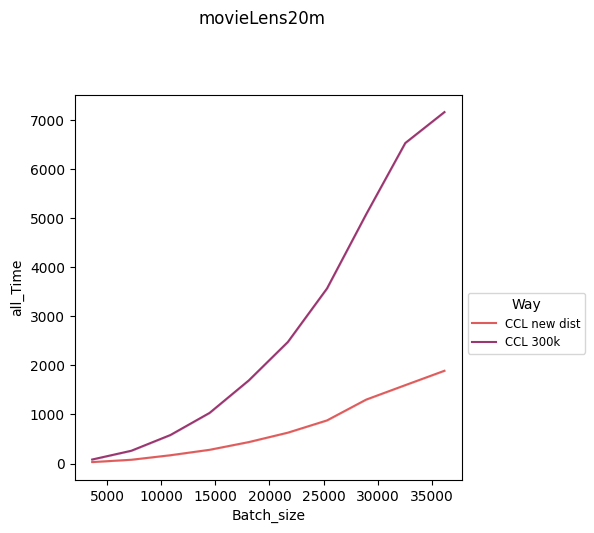

In [ ]:
def line_graph(dataset_name, df, n=10, title=None, x_name='Rank', y_name='Delta', hue_param=None, way=True):
  df['Batch_size'].astype(int)
  confidence_level=0.95
  t_crit = t.ppf((1 + confidence_level) / 2, df=n - 1)

  if way == False:
    fig, ax =plt.subplots(figsize=(5, 5))
    # sns.lineplot(x=x_name, y=df['Delta']-min(df['Delta']), data=df.query('Dataset == @dataset_name'), legend="full", errorbar=lambda x: (x.mean() - t_crit * x.std(ddof=1)/np.sqrt(len(x)), x.mean() + t_crit * x.std(ddof=1)/np.sqrt(len(x))))
    if hue_param:
      sns.lineplot(x=x_name, y=y_name, data=df.query('Dataset == @dataset_name'), hue=hue_param, palette="flare")
    else:
      sns.lineplot(x=x_name, y=y_name, data=df.query('Dataset == @dataset_name'))
    if dataset_name ==  '':
      sns.lineplot(x=x_name, y=y_name, data=df, legend="full", hue=hue_param)

    # leg = plt.legend(loc="lower left", title="Year")
    # ax.add_artist(leg)
    # h = [plt.plot([],[], ms=i, ls="", marker="_")[0] for i in range(1000, 4000, 1000)]
    # plt.legend(handles=h, labels=range(5, 13), loc=(1.03,0.5), title=hue_param)
    plt.legend(fontsize='small', loc="upper left", bbox_to_anchor=(1, 0.5, 0, 0), title=hue_param)
    # plt.legend(fontsize='small', loc="upper right", bbox_to_anchor=(1, 0.5, 0, 0), title='title_2')
    # plot_errorbars(lambda x: (x.min(), x.max()))
    fig.suptitle(dataset_name, y=1.05)
  else:
    g = sns.FacetGrid(col="Way", data=df.query('Dataset == @dataset_name'), col_wrap=2, hue=hue_param, palette="flare", height=4.5, aspect=1)
    g.map(sns.lineplot, x_name, y_name)
    g.add_legend()
    g.fig.suptitle(dataset_name, y=1.05)


new_df = read_df_s(paths=[
    # '/content/rand_top_small.csv'
    # '/content/ML20m.csv',
    # '/content/MovieLens_10-50_25_tries_old.csv',
    '/content/ML20m_CCL_sklearn_10-100.csv',
    # '/content/CRS_Matrix_80-90.csv'
    # '/content/ML_protes_7_samples.csv',
    # '/content/MovieLens_95_25_tries_const.csv',
    # '/content/MovieLens_95-97_25_tries_const.csv'
    # '/content/MovieLens_80-90_25_tries_const.csv'
    # '/content/ml_economic_2.csv'
    # '/content/MovieLens1m.csv'
    # '/content/ml_economic_2_old.csv'
    # '/content/Industrial_2.csv',
    # '/content/ML_25_tries_protes_7.csv',
    # '/content/ten_datasets_rest_10-70_25_tries.csv'
    # '/content/Small_datasets_comparison_2.csv',
    # '/content/ten_datasets_10-70_25_tries_const.csv'
    # '/content/ML20m.csv',
    # '/content/Batch_size_8_08.csv',
    # '/content/AO_30_50.csv'
])

new_df['Way'] = 'CCL new dist'

old_df = read_df_s(paths=[
    '/content/ML_10-100_CSR_CCL_300k.csv'
    # '/content/ML20m.csv',
    # '/content/MovieLens_80-90_25_tries_const.csv',
    # '/content/MovieLens_95-97_25_tries_const.csv',
    # '/content/ML_10-100_check_CCL.csv'
])


# print(np.unique(old_df.Dataset))

# last_bs = sorted(np.unique(new_df.Batch_size))[6]
# new_df = new_df[new_df['Batch_size'] <= last_bs]


old_df['Way'] = 'CCL 300k'

# # old_df = pd.concat([f_old_df, s_old_df, t_old_df])
# # new_df = new_df[new_df.index % 25 == 4]

# new_df.head(100)
df = pd.concat([new_df, old_df])
# df = df[df.Rank == 3000]
# # df = df[df.Dataset == 'Arts_Crafts_and_Sewing']
# # # print(np.unique(old_df.Batch_size))
datasets = np.unique(new_df.Dataset)

for ds in datasets:
  # df=df.loc[[0, 25, 50, 75, 100]]
  # df['Variance'] = np.square(df['Std_delta'])
  # print(df.Delta)

  line_graph(ds, df, n=25, title=str(ds), way=False, x_name='Batch_size', y_name='all_Time', hue_param='Way')
  # sns.lineplot(x=df.Batch_size, y=df.Dispersion, legend="full")
  pdf = PdfPages(str(ds) + ".pdf")
  pdf.savefig()
  pdf.close()

#Box Plots

<ipython-input-45-1d1d9c434973>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_new_df = new_df[(df[x_name] == max_x_name)]
<ipython-input-45-1d1d9c434973>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_new_df = new_df[(df[x_name] == max_x_name)]


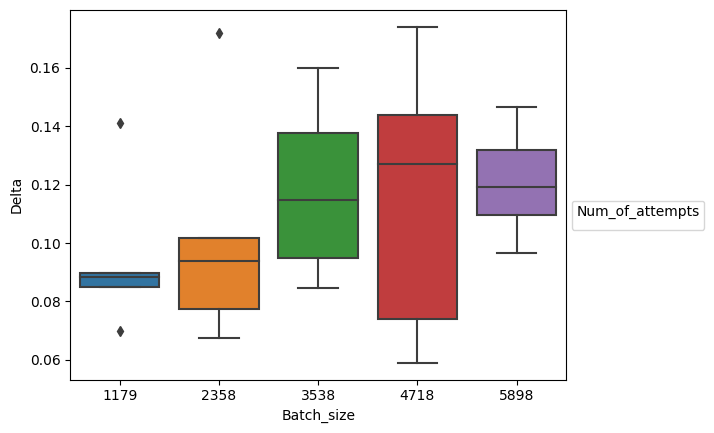

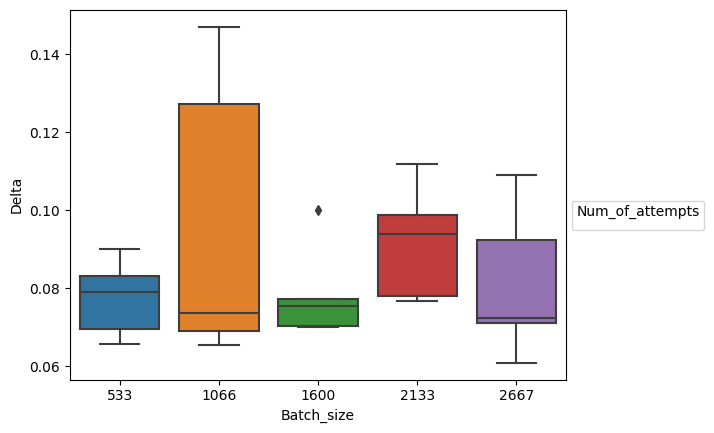

In [ ]:
def box_plot(dataset_name, df, title=None, x_name='Rank', y_name='Delta', hue_param='Batch_size', way=False):

  df['Batch_size'].astype(int)

  new_df = df.query('Dataset == @dataset_name')
  max_x_name = new_df[x_name].max()
  new_new_df = new_df[(df[x_name] == max_x_name)]
  if way:
    g = sns.FacetGrid(new_new_df, col='Way', col_wrap=2, height=4.5, aspect=1)
    #                                               change this to 4 ^
    g.map(sns.boxplot, x_name, y_name, hue_param, palette='flare')
    g.add_legend(title=hue_param)
    g.fig.suptitle(dataset_name, y=1.05)
    # g.map(sns.boxplot, data=new_new_df.query('Way=="old"'), x=x_name, y=y_name, hue=hue_param, palette="flare")
  else:
    fig, ax = plt.subplots()
    ax=sns.boxplot(x=x_name, y=y_name, data=new_df)
  plt.legend(fontsize='small', loc='best', bbox_to_anchor=(1, 0.5, 0, 0), title=hue_param)

df = read_df_s(paths=['/content/Batch_size_medium_10-50.csv'])
# # datasets = ['Magazine_Subscriptions', 'All_Beauty', 'AMAZON_FASHION', 'Appliances', 'Gift_Cards']
datasets= ['Digital_Music','Industrial_and_Scientific']
# # datasets=['Arts_Crafts_and_Sewing','Automotive','Books','CDs_and_Vinyl','Cell_Phones_and_Accessories']
for ds in datasets:
  box_plot(ds, df, title=str(ds), x_name='Batch_size', y_name='Delta', hue_param='Num_of_attempts')


#Mistakes

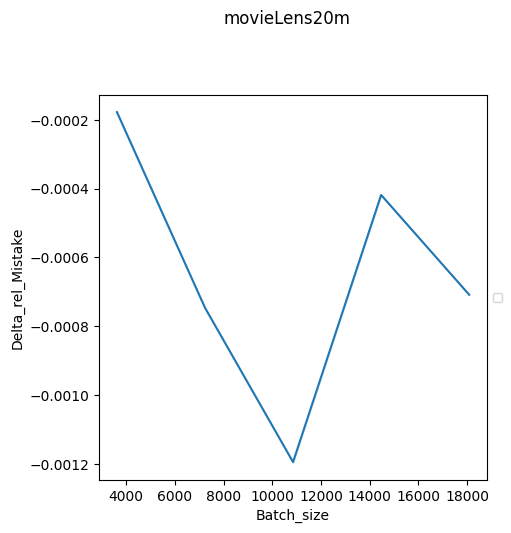

In [ ]:
def build_rel_mistake(new_df, old_df):
  res_df = pd.DataFrame(columns=['Rank', 'Batch_size', 'Delta_rel_Mistake', 'Dataset'])
  res_df['Rank'] = new_df['Rank']
  res_df['Dataset'] = new_df['Dataset']
  res_df['Batch_size'] = new_df['Batch_size']
  # res_df['Delta_rel_Mistake'] = new_df['Mean_delta'].to_numpy() - old_df['Mean_delta'].to_numpy() / old_df['Mean_delta'].to_numpy()
  res_df['Delta_rel_Mistake'] = (new_df['Mean_delta'].to_numpy() - old_df['Mean_delta'].to_numpy())

  return res_df


df_new = read_df_s(paths=[
  # '/content/AO_30_50.csv',
  # '/content/Batch_size_8_08.csv'
  '/content/MovieLens_10-50_25_tries_new.csv'
  # '/content/ML20m.csv',
  # '/content/Industrial_10-70.csv',
  # '/content/V_10-50_10_tries.csv'
  ])

# last_b_s = sorted(np.unique(df_new['Batch_size']))[4]
# df_new = df_new[df_new['Batch_size'] <= last_b_s]

df_old = read_df_s(paths=[
    # '/content/AO_30_50.csv',
    # '/content/Batch_size_8_08.csv'
    # '/content/Digital_10-80_10_tries.csv',
    '/content/MovieLens_10-50_25_tries_old.csv',
    # '/content/V_10-50_10_tries.csv'
    ])
# last_b_s = sorted(np.unique(df_old['Batch_size']))[4]
# df_old = df_old[df_old['Batch_size'] <= last_b_s]

res_df = build_rel_mistake(df_new, df_old)
ds='movieLens20m'
line_graph(dataset_name=ds, df=res_df, n=25, title=str(ds), way=False, x_name='Batch_size', y_name='Delta_rel_Mistake')

#Generalisation

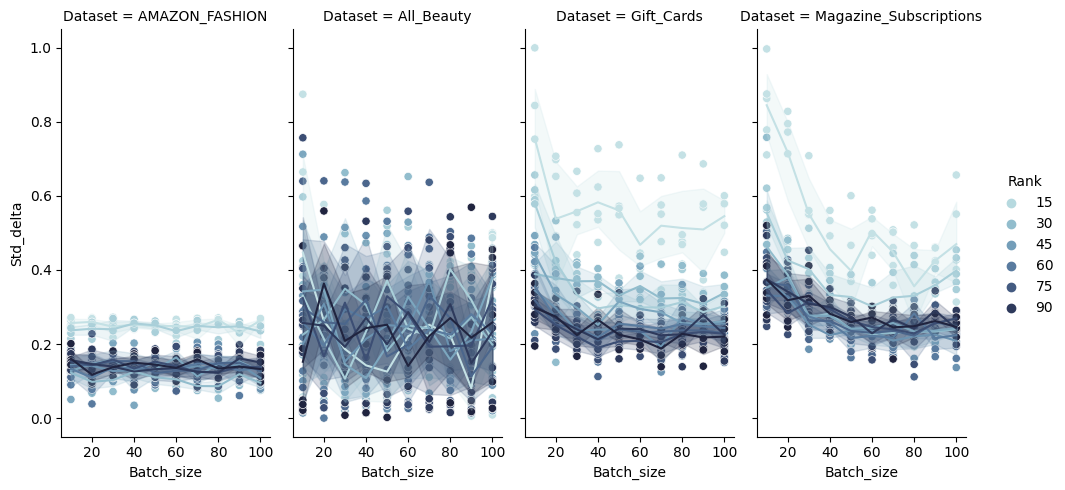

In [ ]:

df = pd.read_csv('/content/Rank_Batch_size_N_tries.csv')

df = df.drop(df.columns[[0, 1, 8, 9, 10]], axis = 1).drop_duplicates()

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
datasets = ['Magazine_Subscriptions', 'All_Beauty', 'AMAZON_FASHION', 'Appliances', 'Gift_Cards']
df = df.drop(df[df.Dataset == 'Appliances'].index)
df['Std_delta']=((df['Std_delta']-df['Std_delta'].min())/(df['Std_delta'].max()-df['Std_delta'].min()))


g = sns.relplot(
    data=df,
    x="Batch_size", y="Std_delta",
    hue="Rank",
    palette=cmap, col='Dataset', aspect=.5
)

# g = sns.FacetGrid(
#     data=df,
#     palette=cmap, col='Dataset'
# )

# sns.catplot(
#     data=df, kind="strip",  jitter=0.5,
#     x="Batch_size", y="Std_delta", hue="Rank", col="Dataset",
#     aspect=.7, alpha=0.5, legend='full'
# )

# g = sns.FacetGrid(df, col="Dataset",col_wrap=5, aspect=.7)
#                                               change this to 4 ^
# g.map(sns.lmplot, x='Batch_size', 'Std_delta', hue='Rank', palette='flare')
g.map(sns.lineplot,'Batch_size', 'Std_delta', 'Rank', palette=cmap)
# g=sns.lmplot(
#   data=df, x="Rank", y="Std_delta",col='Dataset', row="Num_of_attempts",
#   hue="Batch_size",
#   palette='flare', aspect=.85
# )

# for ax in g.axes.flat:
#   ax.xaxis.grid( visible=True)
#   ax.yaxis.grid( visible=True)
# for ax in g.axes.flat:
#      ax.set_xlabel(visible=False)
#      ax.set_ylabel(visible=False)
# g.despine(left=True, bottom=True)
pdf = PdfPages("scatter_line.pdf")
pdf.savefig()
pdf.close()

  # g.add_legend(title=ds)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#Time

<ipython-input-22-c343ed8a4869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Time'] = df_1['Time'] - svd_time[dataset_name]
<ipython-input-22-c343ed8a4869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Time'] = df_1['Time'] - svd_time[dataset_name]
<ipython-input-22-c343ed8a4869>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

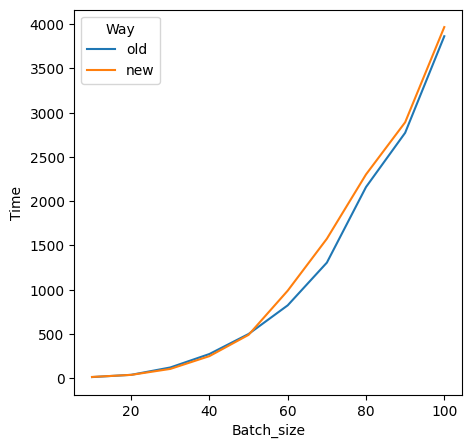

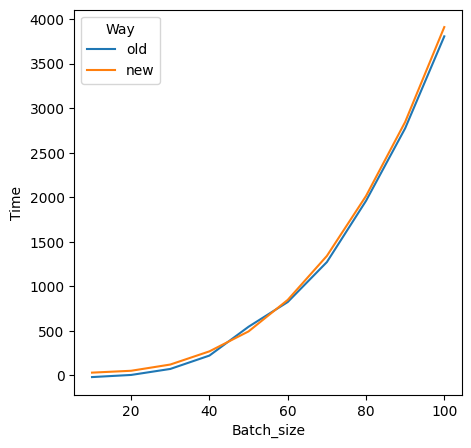

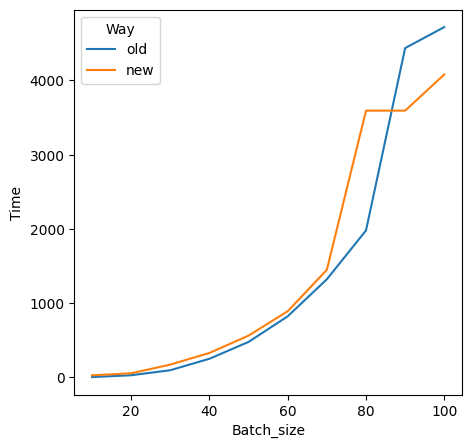

In [ ]:

def line_graph(dataset_name, df, title=None, x_name='Rank', y_name='Delta', hue_param='Batch_size', way=True):

  df['Batch_size'].astype(int)
  df = df.drop(df[df.Batch_size > 100].index)
  df = df.drop(df[df.Rank > 100].index)
  svd_time = {
      'Arts_Crafts_and_Sewing': 24.564814805984497,
      'Grocery_and_Gourmet_Food' : 69.6717438697815,
      'Office_Products': 34.52872705459595
  }

  df_1 = df.query('Dataset == @dataset_name & Way == "old"')
  df_2 = df.query('Dataset == @dataset_name & Way == "new"')

  df_1['Time'] = df_1['Time'] - svd_time[dataset_name]

  df = pd.concat([df_1, df_2])


  fig, ax =plt.subplots(figsize=(5, 5))
  sns.lineplot(x='Batch_size', y=y_name, data=df.query('Dataset == @dataset_name'), hue='Way', legend="full")

df_1 = pd.read_csv('/content/new_normed_Batch_size_Way_Way.csv')
df_2 = pd.read_csv('/content/normed_Batch_size_Way.csv')
df = pd.concat([df_1, df_2])
df_1.head()

# datasets = ['Magazine_Subscriptions', 'All_Beauty', 'AMAZON_FASHION', 'Appliances', 'Gift_Cards']
# datasets= ['Digital_Music','Industrial_and_Scientific','Luxury_Beauty','Prime_Pantry','Software']
# datasets=['Arts_Crafts_and_Sewing','Automotive','Books','CDs_and_Vinyl','Cell_Phones_and_Accessories']
datasets = ['Arts_Crafts_and_Sewing', 'Grocery_and_Gourmet_Food', 'Office_Products']
for ds in datasets:
  line_graph(ds, df, title=str(ds), y_name='', way=False)
  pdf = PdfPages(str(ds) + "_time.pdf")
  pdf.savefig()
  pdf.close()

#Draft

In [ ]:


lst = np.random.randint(0, 9, 20)
print(lst)

std = lst.std(ddof=1)
print(std)
mean = np.mean(lst)

n=len(lst)
# Вычисление критического значения t
# t_crit = t.ppf((1 + 0.05) / 2, df=n - 1)
t_crit = 2.776
# Вычисление доверительного интервала
ci = t_crit * (std / np.sqrt(n))
ci = ci * np.asarray([-1, 1])

coef = 2.776
print(lst.std(ddof=1))
polara_ci = coef * lst.std(ddof=1) / math.sqrt(n)


print('manually ' + str(ci))
print('polara ' + str(polara_ci))





[4 1 3 4 1 1 1 1 6 6 6 8 4 0 2 6 6 7 7 4]
2.5110283068684702
2.5110283068684702
manually [-1.5586768  1.5586768]
polara 1.5586768045533463


In [ ]:


df = read_df_s(paths=['/content/datasets_info.csv','/content/datasets_info_ml.csv'])

df['Dencity'] = round(df.Interactions / (df.Users * df.Items), 5)
df.to_csv('/content/datasets_info.csv')


In [ ]:


df = read_df_s(paths=['/content/datasets_info.csv'])
df.head()

,Unnamed: 0.1,Unnamed: 0,Users,Items,Interactions,Dataset,Dencity
0,0,0.0,406,31,3042,AMAZON_FASHION,0.24170
1,1,1.0,991,85,4092,All_Beauty,0.04858
2,2,2.0,47,48,183,Appliances,0.08112
3,3,3.0,56210,22931,440318,Arts_Crafts_and_Sewing,0.00034
4,4,4.0,193651,79437,1639866,Automotive,0.00011


In [ ]:


dist_matrix = np.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
pairs = []
for i in range(3):
    for j in range(i):
        pairs.append([i, j])
print(pairs)
sorted(pairs, key=lambda x: dist_matrix[x[0],  x[1]])

[[1, 0], [2, 0], [2, 1]]


[[1, 0], [2, 0], [2, 1]]